## Welcome

Welcome to Quantopian. In this tutorial, we introduce Quantopian, the problems it aims to solve, and the tools it provides to help you solve those problems. At the end of this lesson, you should have a high level understanding of what you can do with Quantopian.

The focus of the tutorial is to get you started, not to make you an expert Quantopian user. If you already feel comfortable with the basics of Quantopian, there are other resources to help you learn more about Quantopian's tools:
- [Documentation](https://www.quantopian.com/docs/index)
- [Pipeline Tutorial](https://www.quantopian.com/tutorials/pipeline)
- [Alphalens Tutorial](https://www.quantopian.com/tutorials/alphalens)

All you need to get started on this tutorial is some basic [Python](https://docs.python.org/3.5/) programming skills.

Note: You are currently viewing this tutorial lesson in the Quantopian **Research** environment. Research is a hosted Jupyter notebook environment that allows you to interactively run Python code. Research comes with a mix of proprietary and open-source Python libraries pre-installed. To learn more about Research, see the [documentation](https://www.quantopian.com/docs/user-guide/environments/research). You can follow along with the code in this notebook by cloning it. Each cell of code (grey boxes) can be run by pressing Shift + Enter. **This tutorial notebook is read-only**. If you want to make changes to the notebook, create a new notebook and copy the code from this tutorial. 


## What is Quantopian?

Quantopian is a cloud-based software platform that allows you to research quantitative financial factors in developed and emerging equity markets around the world using Python. Quantopian makes it easy to iterate on ideas by supplying a fast, uniform API on top of all sorts of [financial data](https://www.quantopian.com/docs/data-reference/overview). Additionally, Quantopian provides tools to help you [upload your own financial datasets](https://www.quantopian.com/docs/user-guide/tools/self-serve), analyze the efficacy of your factors, and share your findings with a global community of quants.

Typically, researching cross-sectional equity factors involves the following steps:
1. Define a universe of assets.
2. Define a factor over the universe.
3. Test the factor.
4. Share and discuss results with other quants with an eye toward improving your approach.

On Quantopian, steps 1 and 2 are achieved using [**the Pipeline API**](https://www.quantopian.com/docs/user-guide/tools/pipeline), step 3 is done using a tool called [**Alphalens**](https://www.quantopian.com/docs/user-guide/tools/alphalens), and step 4 is done in the [Quantopian community forum](https://www.quantopian.com/posts). The rest of this tutorial will give a brief walkthrough of an end-to-end factor research workflow on Quantopian.

### Research Environment

The code in this tutorial can be run in Quantopian's **Research** environment (this notebook is currently running in Research). Research is a hosted [Jupyter](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html) notebook environment that allows you to interactively run Python code. Research comes with a mix of proprietary and open-source Python libraries pre-installed. To learn more about Research, see the [documentation](https://www.quantopian.com/docs/user-guide/environments/research). 

Press **Shift+Enter** to run each cell of code (grey boxes).

### Step 1 - Define a universe of assets.

The first step to researching a cross-sectional equity factor is to select a “universe” of equities over which our factor will be defined. In this context, a universe represents the set of equities we want to consider when performing computations later. On Quantopian, defining a universe is done using the [**the Pipeline API**](https://www.quantopian.com/docs/user-guide/tools/pipeline). Later on, we will use the same API to compute factors over the equities in this universe.

The Pipeline API provides a uniform interface to several [built-in datasets](https://www.quantopian.com/docs/data-reference/overview), as well as any [custom datasets](https://www.quantopian.com/custom-datasets) that we upload to our account. Pipeline makes it easy to define computations or expressions using built-in and custom data. For example, the following code snippet imports two built-in datasets, [FactSet Fundamentals](https://www.quantopian.com/docs/data-reference/factset_fundamentals) and [FactSet Equity Metadata](https://www.quantopian.com/docs/data-reference/equity_metadata), and uses them to define an equity universe.

In [1]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.factset import Fundamentals, EquityMetadata

is_share = EquityMetadata.security_type.latest.eq('SHARE')
is_primary = EquityMetadata.is_primary.latest
primary_shares = (is_share & is_primary)
market_cap = Fundamentals.mkt_val.latest

universe = market_cap.top(1000, mask=primary_shares)

The above example defines a universe to be the top 1000 primary issue common stocks ranked by market cap. Universes can be defined using any of the data available on Quantopian. Additionally, you can upload your own data, such as index constituents or another custom universe to the platform using the Self-Serve Data tool. To learn more about uploading a custom dataset, see the [Self-Serve Data documentation](https://www.quantopian.com/docs/user-guide/tools/self-serve). For now, we will stick with the universe definition above.

### Step 2 - Define a factor.

After defining a universe, the next step is to define a factor for testing. On Quantopian, a factor is a computation that produces numerical values at a regular frequency for all assets in a universe. Similar to step 1, we will use the [**the Pipeline API**](https://www.quantopian.com/docs/user-guide/tools/pipeline) to define factors. In addition to providing a fast, uniform API on top of pre-integrated and custom datasets, Pipeline also provides a set of built-in [classes](https://www.quantopian.com/docs/api-reference/pipeline-api-reference#built-in-factors) and [methods](https://www.quantopian.com/docs/api-reference/pipeline-api-reference#methods-that-create-factors) that can be used to quickly define factors. For example, the following code snippet defines a momentum factor using fast and slow moving average computations.

In [2]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import EquityPricing
from quantopian.pipeline.factors import SimpleMovingAverage

# 1-month (21 trading day) moving average factor.
fast_ma = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=21)

# 6-month (126 trading day) moving average factor.
slow_ma = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=126)

# Divide fast_ma by slow_ma to get momentum factor and z-score.
momentum = fast_ma / slow_ma
momentum_factor = momentum.zscore()

Now that we defined a universe and a factor, we can choose a market and time period and simulate the factor. One of the defining features of the Pipeline API is that it allows us to define universes and factors using high level terms, without having to worry about common data engineering problems like [adjustments](https://www.quantopian.com/docs/data-reference/overview#corporate-action-adjustments), [point-in-time data](https://www.quantopian.com/docs/data-reference/overview#point-in-time-data), [symbol mapping](https://www.quantopian.com/docs/data-reference/overview#asset-identifiers), delistings, and data alignment. Pipeline does all of that work behind the scenes and allows us to focus our time on building and testing factors.

The below code creates a Pipeline instance that adds our factor as a column and screens down to equities in our universe. The Pipline is then run over the US equities market from 2016 to 2019. 

In [3]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import EquityPricing
from quantopian.pipeline.data.factset import Fundamentals, EquityMetadata
from quantopian.pipeline.domain import US_EQUITIES, ES_EQUITIES
from quantopian.pipeline.factors import SimpleMovingAverage

is_share = EquityMetadata.security_type.latest.eq('SHARE')
is_primary = EquityMetadata.is_primary.latest
primary_shares = (is_share & is_primary)
market_cap = Fundamentals.mkt_val.latest

universe = market_cap.top(1000, mask=primary_shares)

# 1-month moving average factor.
fast_ma = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=21)

# 6-month moving average factor.
slow_ma = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=126)

# Divide fast_ma by slow_ma to get momentum factor and z-score.
momentum = fast_ma / slow_ma
momentum_factor = momentum.zscore()


# Create a US equities pipeline with our momentum factor, screening down to our universe.
pipe = Pipeline(
    columns={
        'momentum_factor': momentum_factor,
    },
    screen=momentum_factor.percentile_between(50, 100, mask=universe),
    domain=US_EQUITIES,
)

# Run the pipeline from 2016 to 2019 and display the first few rows of output.
from quantopian.research import run_pipeline
factor_data = run_pipeline(pipe, '2016-01-01', '2019-01-01')
print("Result contains {} rows of output.".format(len(factor_data)))
factor_data.head()

Result contains 376888 rows of output.


momentum_factor
2016-01-04 00:00:00+00:00 Equity(67 [ADSK])          1.211037
                          Equity(76 [TAP])           1.252325
                          Equity(114 [ADBE])         0.816440
                          Equity(161 [AEP])          0.407423
                          Equity(185 [AFL])          0.288431

Running the above code produces a pandas dataframe, stored in the variable `factor_data`, and display the first few rows of its output. The dataframe contains a momentum factor value per equity per day, for each equity in our universe, based on the definition we provided. Now that we have a momentum value for each equity in our universe, and each day between 2016 and 2019, we can test to see if our factor is predictive.

**Note:** Due to licensing restrictions, some datasets on Quantopian have [holdouts](https://www.quantopian.com/docs/data-reference/overview#holdout-periods) on the most recent year or two of data. Each dataset is documented with the length of holdout on recent data. For instance, FactSet Fundamentals has the most recent year of data held out. Holdouts to not apply to [Quantopian Enterprise](https://factset.quantopian.com).


### Step 3 - Test the factor.

The next step is to test the predictiveness of the factor we defined in step 2. In order to determine if our factor is predictive, load returns data from Pipeline, and then feed the factor and returns data into [**Alphalens**](https://www.quantopian.com/docs/user-guide/tools/alphalens). The following code cell loads the 1-day trailing returns for equities in our universe, shifts them back, and formats the data for use in Alphalens.

In [4]:
from quantopian.pipeline.factors import Returns

# Create and run a Pipeline to get day-over-day returns.
returns_pipe = Pipeline(
    columns={
        '1D': Returns(window_length=2),
    },
    domain=US_EQUITIES,
)
returns_data = run_pipeline(returns_pipe, '2016-01-01', '2019-02-01')

# Import alphalens and pandas.
import alphalens as al
import pandas as pd

# Shift the returns so that we can compare our factor data to forward returns.
shifted_returns = al.utils.backshift_returns_series(returns_data['1D'], 2)

# Merge the factor and returns data.
al_returns = pd.DataFrame(
    data=shifted_returns, 
    index=factor_data.index,
    columns=['1D'],
)
al_returns.index.levels[0].name = "date"
al_returns.index.levels[1].name = "asset"

# Format the factor and returns data so that we can run it through Alphalens.
al_data = al.utils.get_clean_factor(
    factor_data['momentum_factor'],
    al_returns,
    quantiles=5,
    bins=None,
)

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Then, we can create a factor tearsheet to analyze our momentum factor. 

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.074955,0.421041,0.210313,0.087290,75500,20.047423
2,0.036037,0.549411,0.344777,0.088091,75320,19.999628
3,0.176786,0.749339,0.492666,0.094418,74974,19.907755
4,0.334028,1.049384,0.693494,0.116546,75320,19.999628
5,0.550049,8.979527,1.236411,0.522688,75493,20.045565


Returns Analysis


,1D
Ann. alpha,-0.010
beta,0.113
Mean Period Wise Return Top Quantile (bps),0.194
Mean Period Wise Return Bottom Quantile (bps),-0.432
Mean Period Wise Spread (bps),0.626


/venvs/py35/lib/python3.5/site-packages/alphalens/tears.py:275: UserWarning: 'freq' not set in factor_data index: assuming business day
  UserWarning,


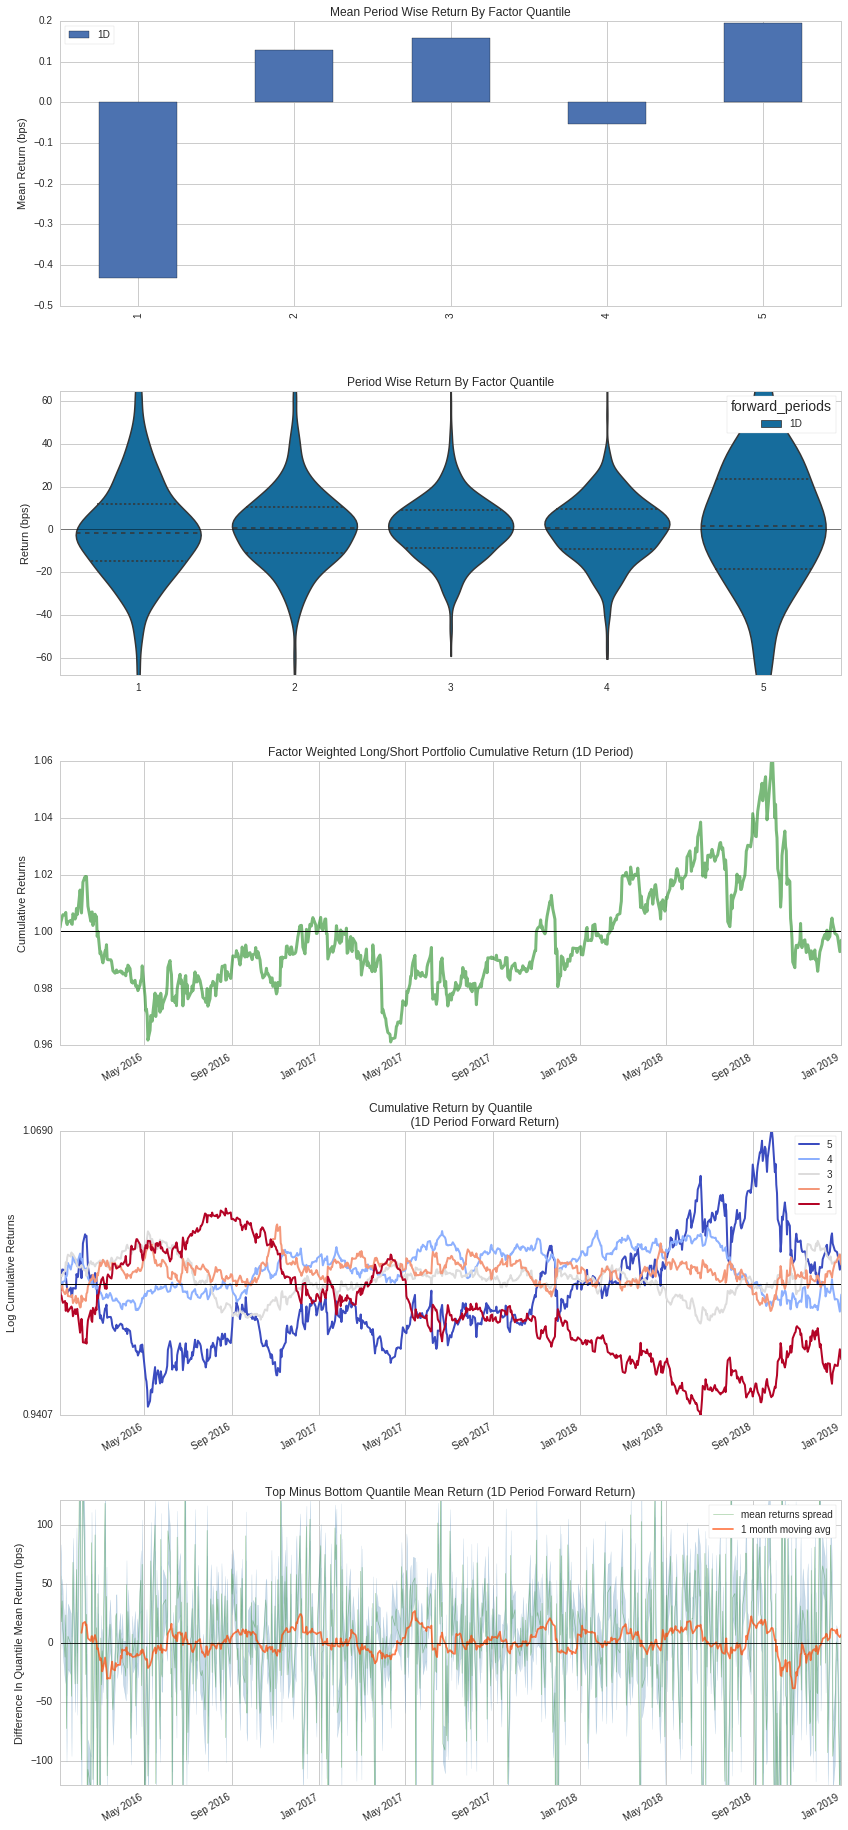

Information Analysis


,1D
IC Mean,0.005
IC Std.,0.135
Risk-Adjusted IC,0.038
t-stat(IC),1.034
p-value(IC),0.301
IC Skew,-0.288
IC Kurtosis,0.007


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


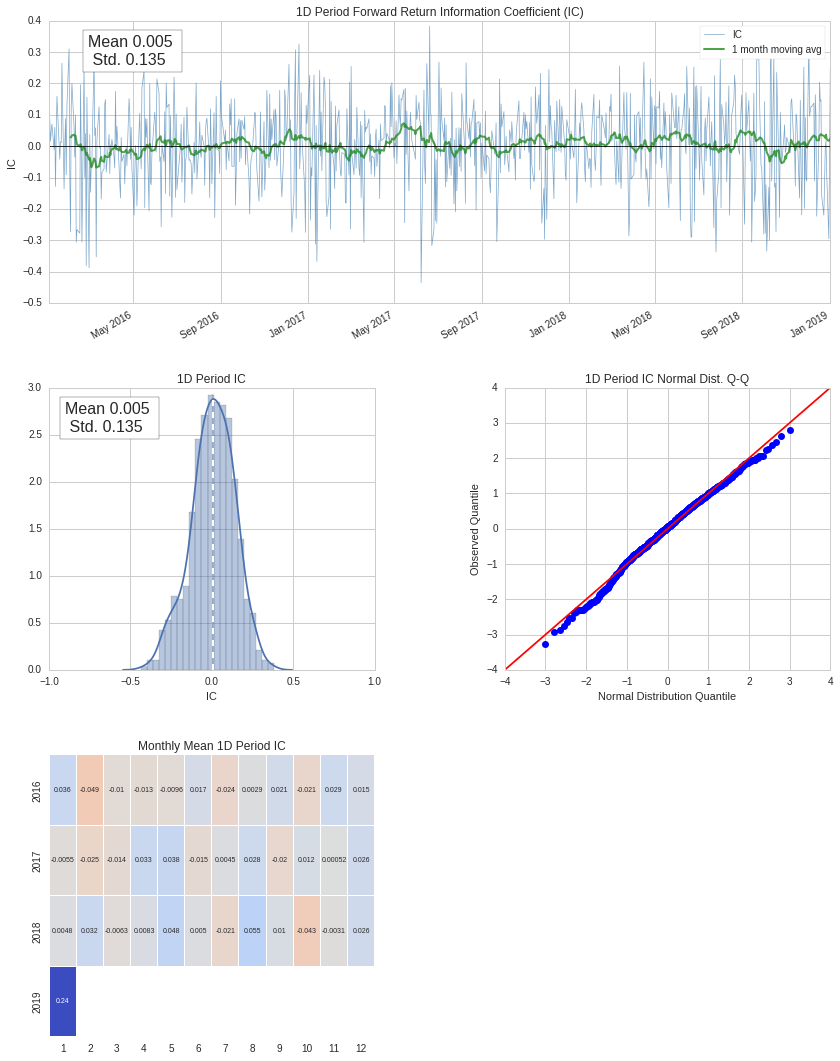

/venvs/py35/lib/python3.5/site-packages/alphalens/utils.py:912: UserWarning: Skipping return periods that aren't exact multiples of days.
  + " of days."


Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.117
Quantile 2 Mean Turnover,0.111
Quantile 3 Mean Turnover,0.096
Quantile 4 Mean Turnover,0.070
Quantile 5 Mean Turnover,0.030


,1D
Mean Factor Rank Autocorrelation,0.996


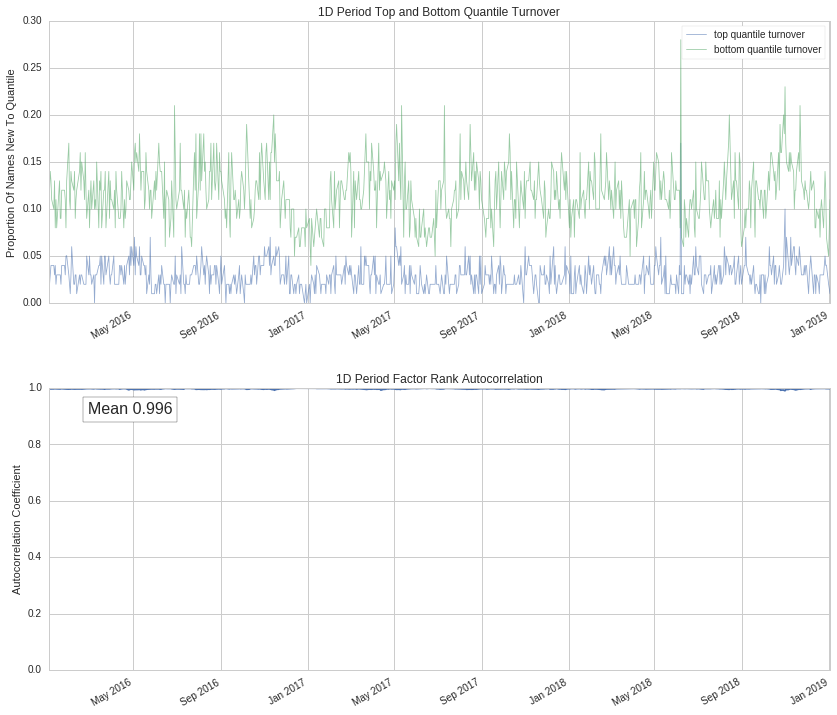

In [5]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(al_data)

The Alphalens tearsheet offers insight into the predictive ability of a factor. 

To learn more about Alphalens, check out the [documentation](https://www.quantopian.com/docs/user-guide/tools/alphalens).

### Step 4 - Discuss with the Quantopian Community

When we have a factor that we like, we can share the result in the [Quantopian community forum](https://www.quantopian.com/posts) and solicit feedback from community members. The ideas you come up with on Quantopian belong to you, but sometimes sharing a result can spark a discussion and create an opportunity to learn from others. In the community forum, Research notebooks can be attached to posts. If you want to share the result of your work **and** the code, you can share your notebook as is. If you want to keep the code to yourself, you can create a copy of your notebook, run your factor through Alphalens, delete the code cells that have your Pipeline code, and just share the Alphalens result in a community post.

If you want to share your work or your result in the community, make sure to provide an explanation of some sort and ask questions to make it more likely that others will respond!


### Recap & Next Steps

In this tutorial, we introduced Quantopian and walked through a factor research workflow using Pipeline and Alphalens. Quantopian has a rich set of [documentation](https://www.quantopian.com/docs/index) which you can use to learn more about the platform. We recommend starting with the [User Guide](https://www.quantopian.com/docs/user-guide/overview) section of the documentation if you would like to grow your understanding of Quantopian or the [Data Reference](https://www.quantopian.com/docs/data-reference/overview) if you want to learn more about the data that's available to you out of the box.

If you would like to learn more about [Quantopian's enterprise offering](https://factset.quantopian.com/home), please contact us at enterprise@quantopian.com.